<a href="https://colab.research.google.com/github/UKashNK/Car-Insurance-data/blob/main/Car_Insurance_Claims_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car Insurance Claims

## Loading data and imports

### Imports and Custom Functions

In [115]:
# Loading Imports
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno as msno
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

#Machine Learning modules
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.inspection import permutation_importance

#Classification modules
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay

#Feature Engineering
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
#Visualisation functions

#Univariate function
def univ_viz(dataf,col,figsize=(10,6)):

  if dataf[col].dtype == "float64":
    #Drawing plot for numeric type feature
    fig, ax = plt.subplots(constrained_layout=True,figsize=figsize)
    ax = sns.histplot(dataf,x=col,ax=ax)
    ax.set(title=f"Univariate visualization showing the distribution of {col}.",xlabel=col,ylabel=target);
    plt.tight_layout();

  else:
    #Drawing plot for categorical type feature
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.countplot(dataf,x=col,ax=ax)
    ax.set(title=f"Univariate visualization showing the distribution of {col}.",xlabel=col,ylabel="Number of claims");
    plt.tight_layout();


#Multivariate function
def multi_viz(dataf,col,target,figsize=(10,6)):
  if dataf[col].dtype == "float64":
    #Calculating correlation
    corr = dataf[[col,target]].corr().round(2)
    r = str(corr.loc[col,target])

    #Drawing plot for numeric type feature
    fig, ax = plt.subplots(constrained_layout=True,figsize=figsize)

    line_kws={"color":"red","label":f"Correlation:{r}"}
    scatter_kws={"edgecolor":"orange"}

    sns.regplot(data=dataf, x=col, y=target, ax=ax, scatter_kws=scatter_kws,line_kws=line_kws);
    ax.set(title=f"Multivariate visualization plotting {col} vs. {target}.",xlabel=col,ylabel=target);
    ax.legend();

  else:
    #Drawing plot for categorical type feature
    fig, ax = plt.subplots(figsize=figsize)
    sns.countplot(data=dataf,x=col,hue=target,palette=['red','green'],ax=ax);
    ax.set(title=f"Multivariate visualization plotting {col} vs. {target}.",xlabel=col,ylabel='Number of Claims');
    if col == 'ANNUAL_MILEAGE':
      ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
    ax.legend();
    plt.tight_layout();

In [72]:
#Defining functions
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict






### Loading Data

In [73]:
#Loading Data
url = '/content/drive/MyDrive/Car_Insurance_Claim.csv'
df = pd.read_csv(url)
df = df.set_index('ID').sort_index()
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
101,65+,female,majority,10-19y,university,upper class,0.459011,0.0,before 2015,1.0,1.0,92101,10000.0,sedan,1,0,0,0.0
125,40-64,male,majority,20-29y,university,upper class,0.644759,1.0,after 2015,0.0,0.0,10238,15000.0,sedan,4,1,4,0.0
166,16-25,male,majority,0-9y,university,upper class,0.531614,1.0,after 2015,0.0,0.0,10238,15000.0,sedan,0,0,0,0.0
186,26-39,male,majority,0-9y,high school,working class,0.470394,0.0,before 2015,1.0,1.0,32765,8000.0,sedan,0,0,0,0.0
217,16-25,male,majority,0-9y,none,poverty,NaN,0.0,before 2015,0.0,0.0,10238,17000.0,sedan,0,0,0,0.0


Explore and cleaning data

In [74]:
#Exploring
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 101 to 999976
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non-null  i

In [75]:
#Cleaning data
df.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [76]:
#Droping empty values
df.dropna(inplace=True)

In [77]:
df.dtypes

AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object

In [78]:
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
101,65+,female,majority,10-19y,university,upper class,0.459011,0.0,before 2015,1.0,1.0,92101,10000.0,sedan,1,0,0,0.0
125,40-64,male,majority,20-29y,university,upper class,0.644759,1.0,after 2015,0.0,0.0,10238,15000.0,sedan,4,1,4,0.0
166,16-25,male,majority,0-9y,university,upper class,0.531614,1.0,after 2015,0.0,0.0,10238,15000.0,sedan,0,0,0,0.0
186,26-39,male,majority,0-9y,high school,working class,0.470394,0.0,before 2015,1.0,1.0,32765,8000.0,sedan,0,0,0,0.0
226,26-39,male,majority,0-9y,none,poverty,0.454177,1.0,before 2015,0.0,0.0,10238,15000.0,sedan,0,0,0,1.0


## Exploratory Visulisation

<ipython-input-71-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-71-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-71-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-71-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-71-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-71-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


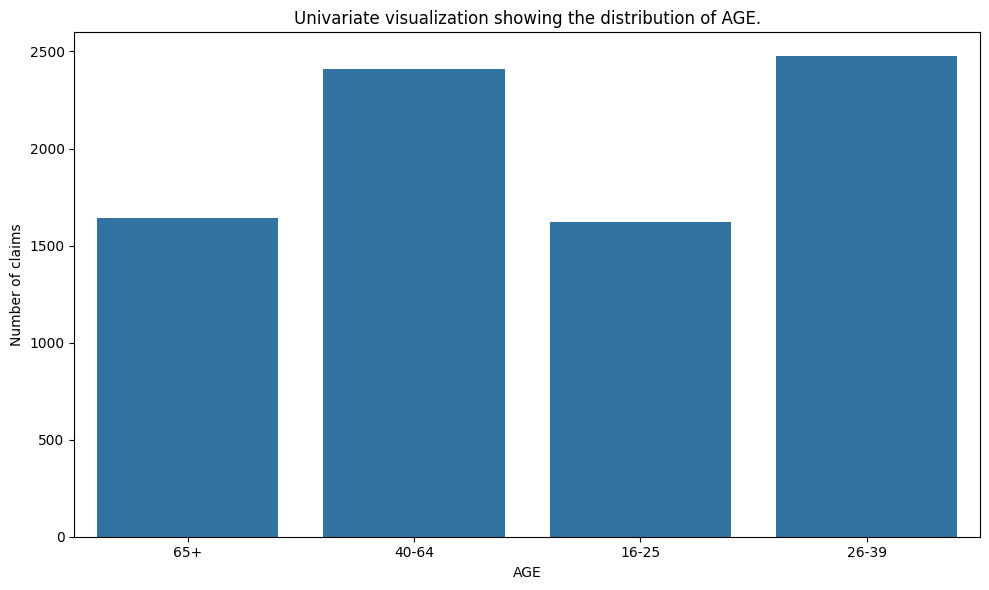

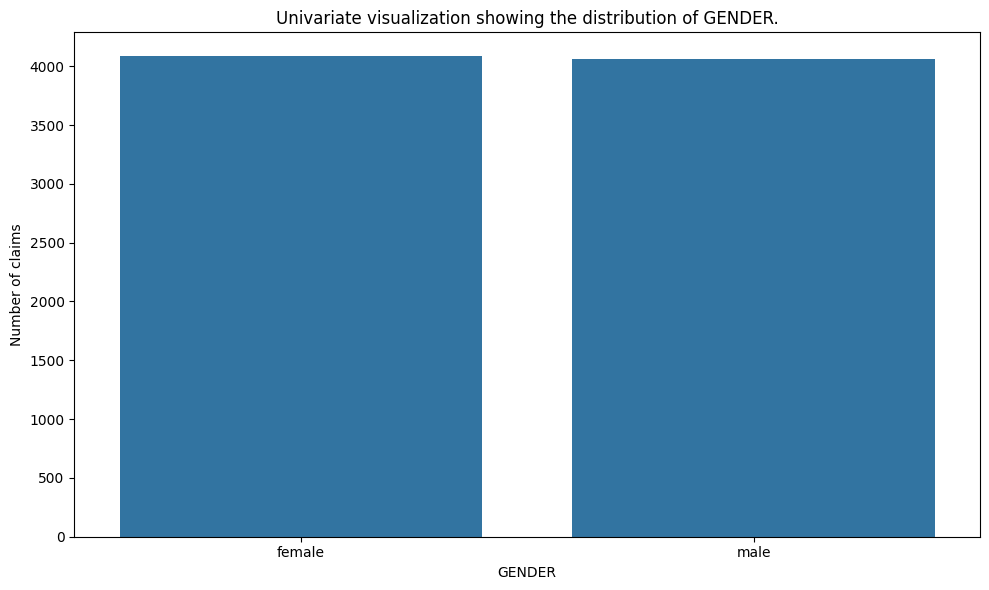

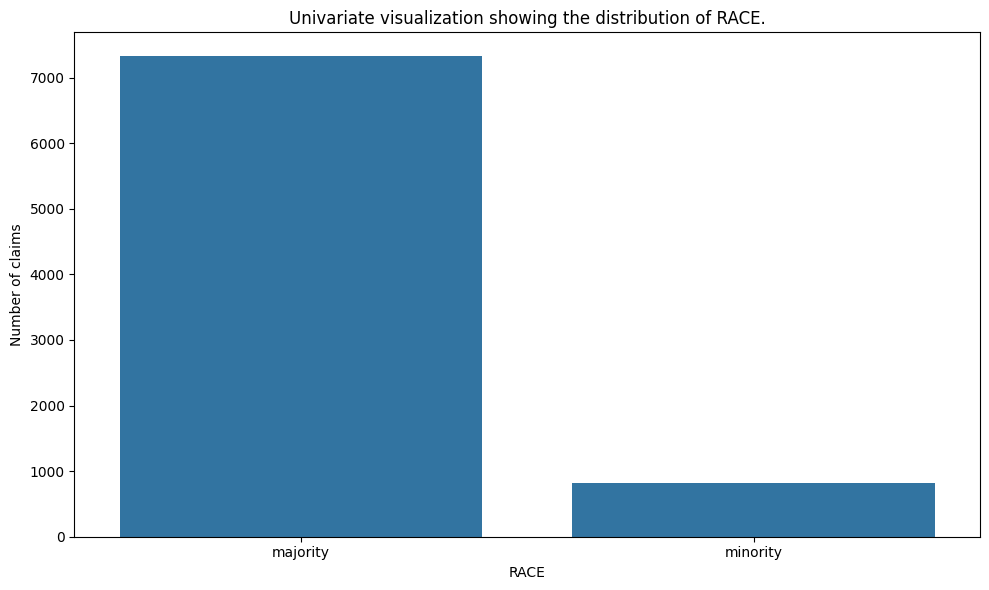

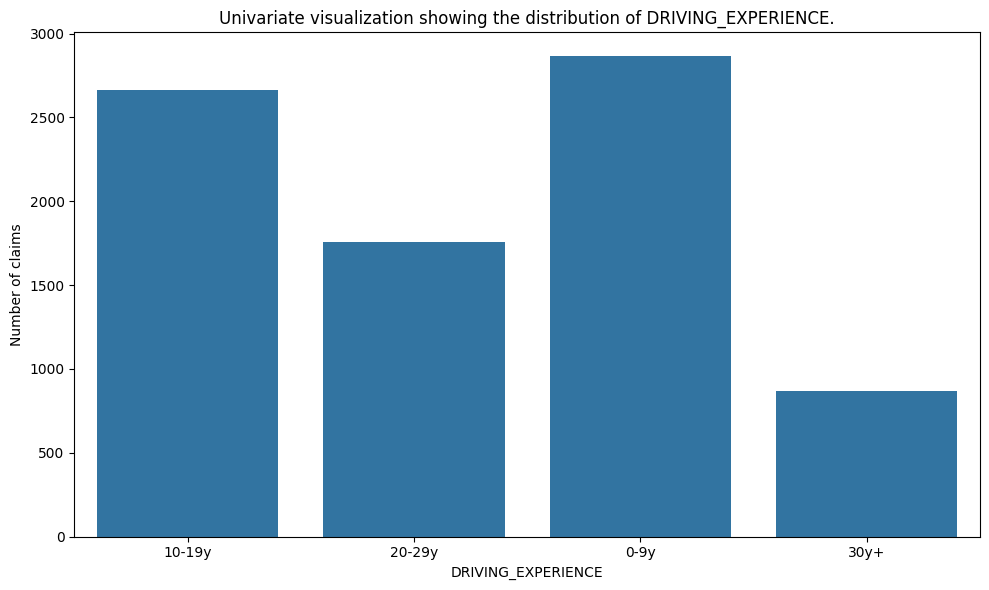

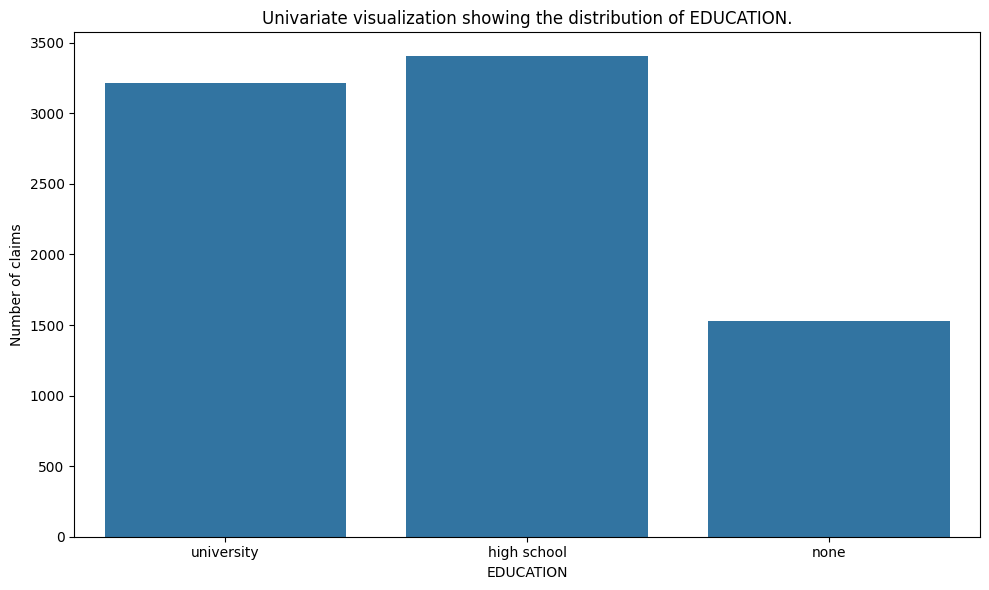

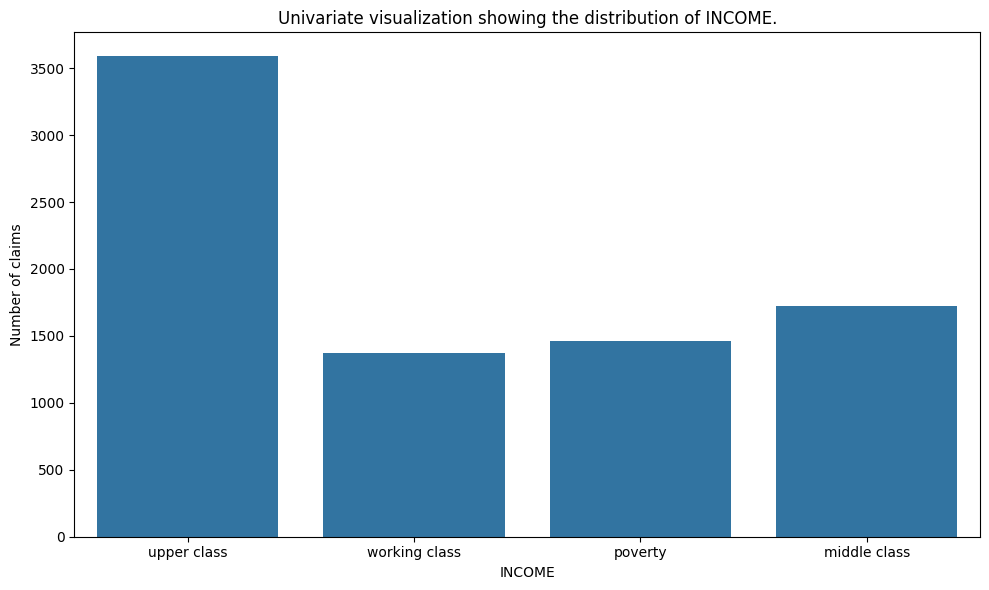

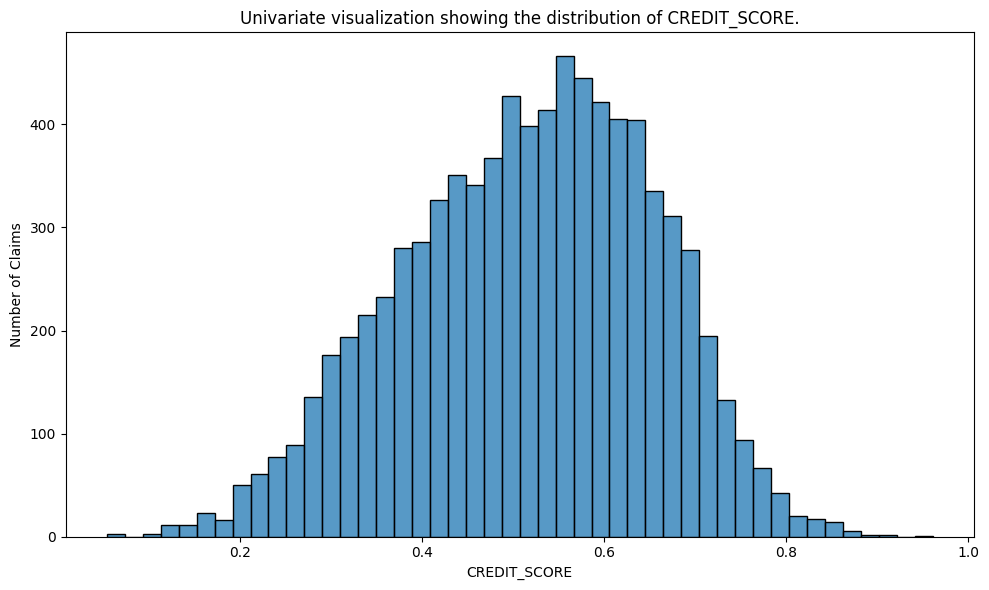

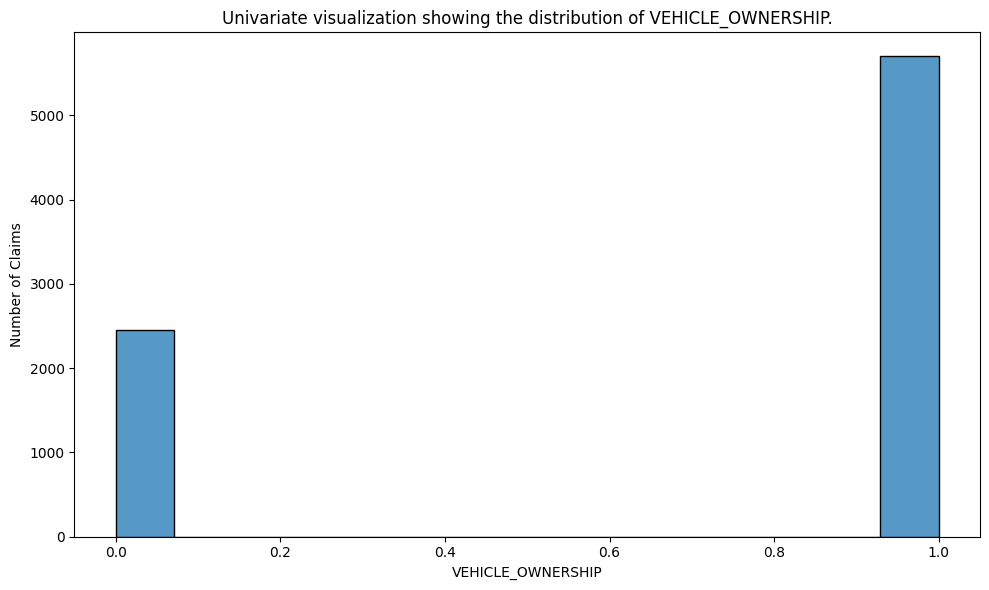

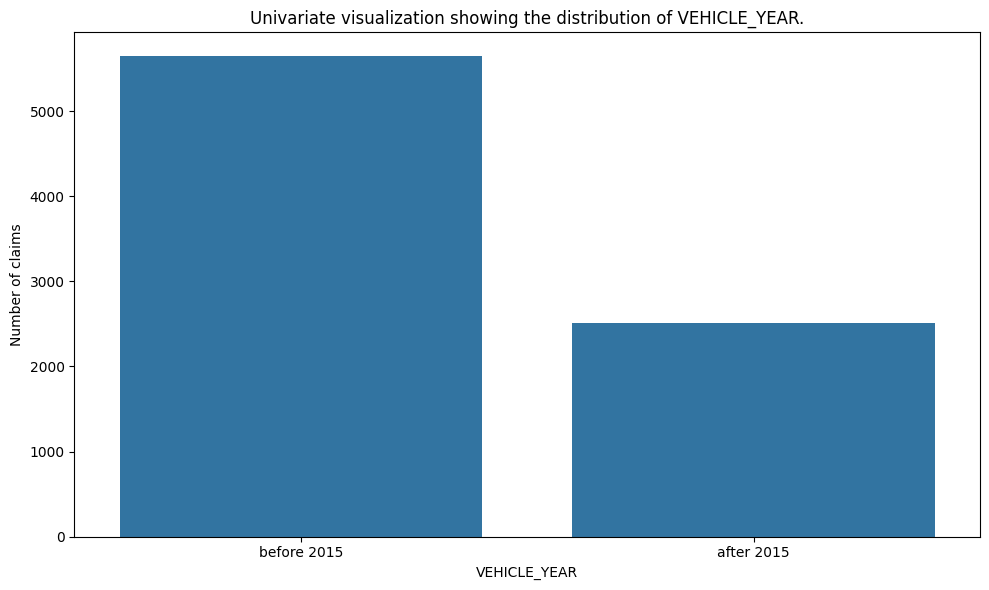

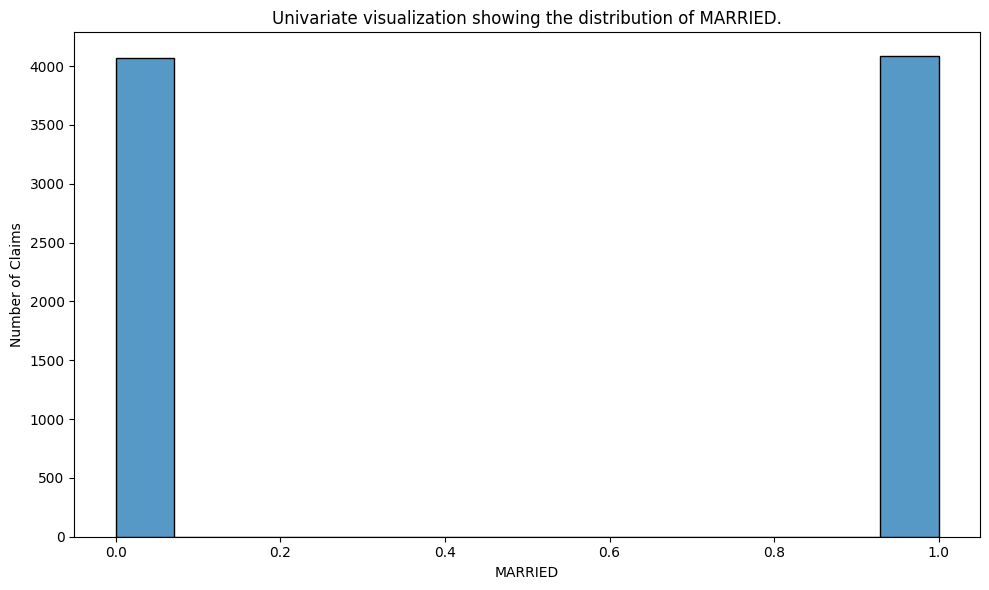

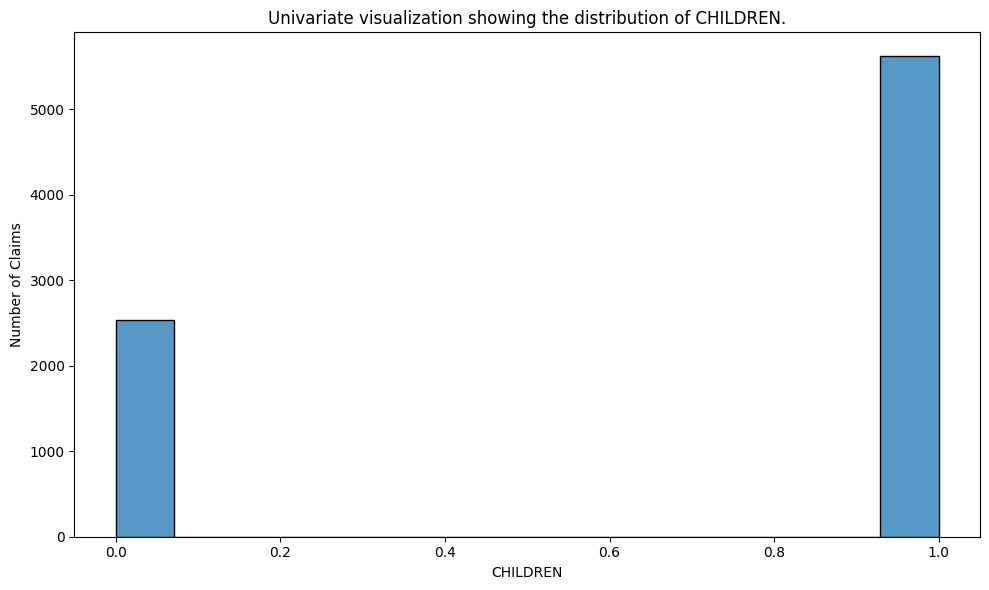

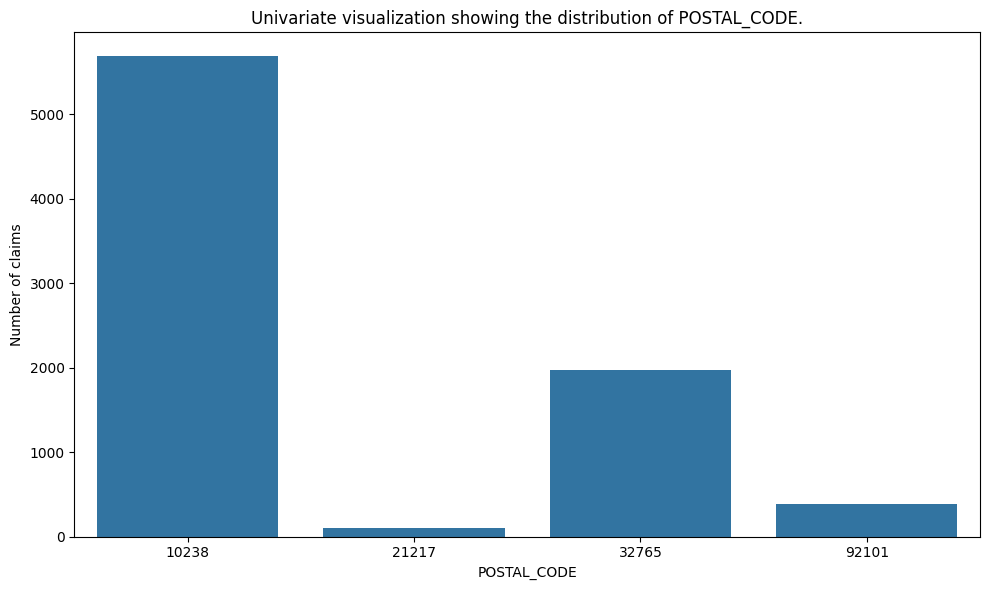

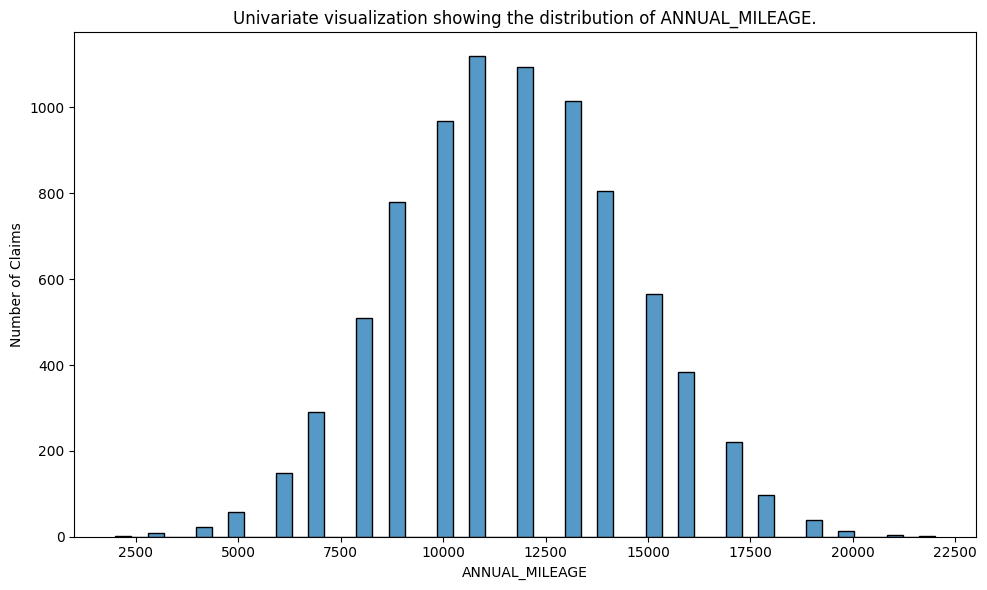

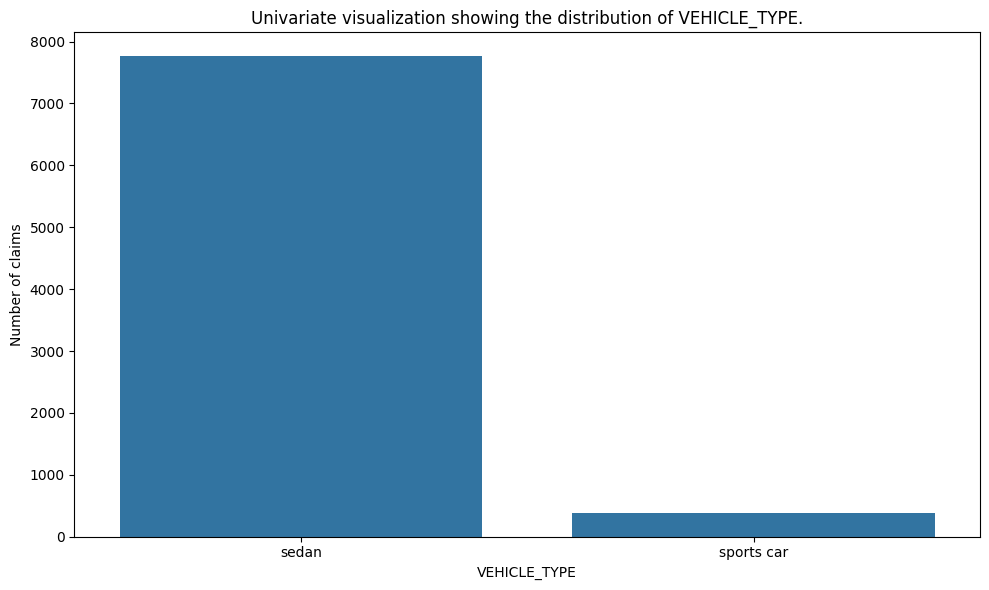

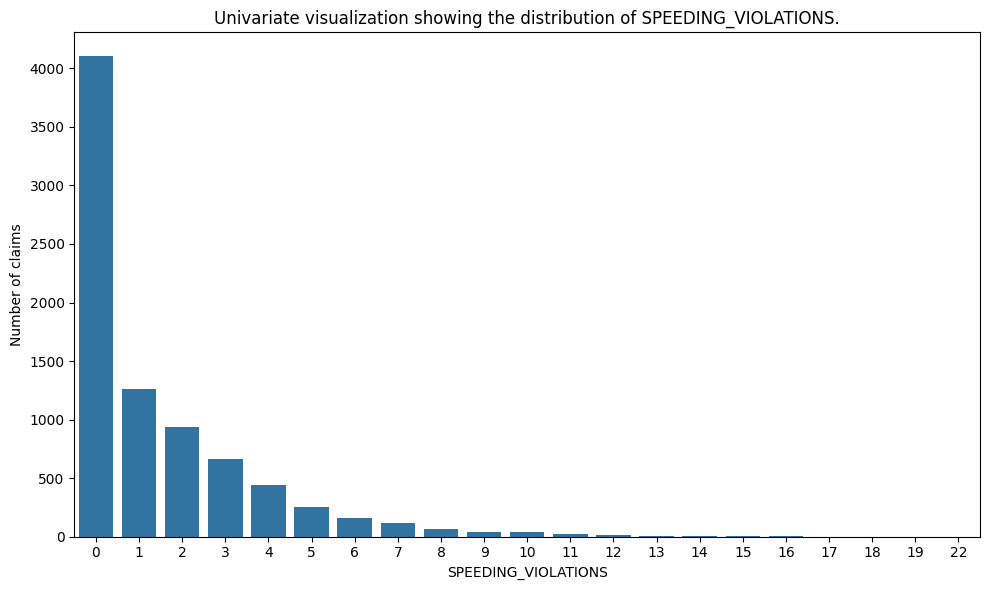

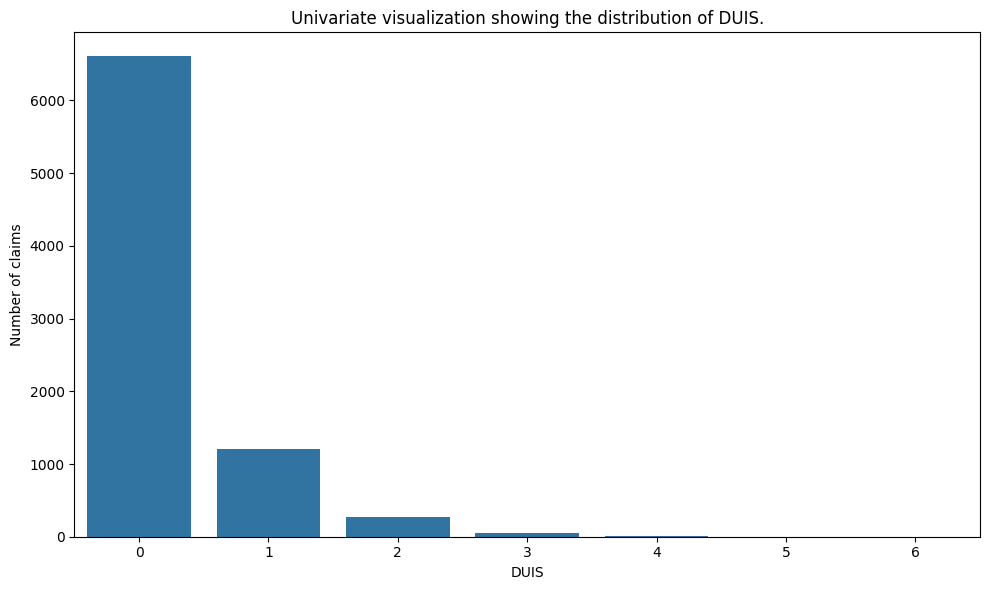

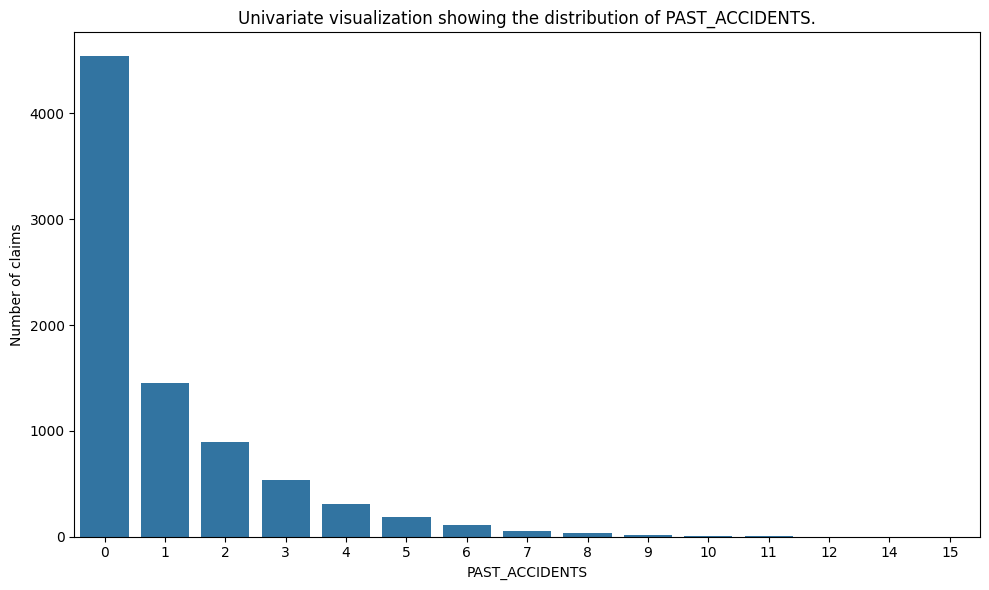

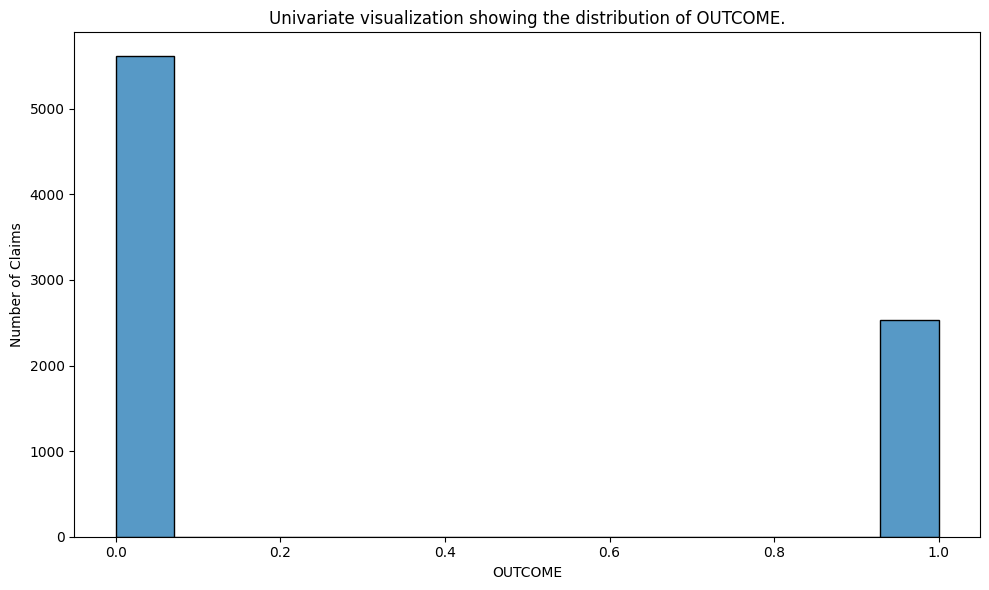

In [79]:
#Univariate visulisations of all columns
for col in df.columns:
  univ_viz(df,col)


##Modeling Data

### Preprocessing data


In [80]:
#Train test split
X = df.drop(columns="OUTCOME")
y = df["OUTCOME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
X_train.dtypes

AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
dtype: object

In [82]:
#Investigating value counts for object datatype
for col in X_train.columns:
  if X_train[col].dtype == "object":
    print(X_train[col].value_counts())
    print()

AGE
26-39    1986
40-64    1925
65+      1316
16-25    1292
Name: count, dtype: int64

GENDER
male      3271
female    3248
Name: count, dtype: int64

RACE
majority    5864
minority     655
Name: count, dtype: int64

DRIVING_EXPERIENCE
0-9y      2292
10-19y    2136
20-29y    1390
30y+       701
Name: count, dtype: int64

EDUCATION
high school    2738
university     2565
none           1216
Name: count, dtype: int64

INCOME
upper class      2866
middle class     1368
poverty          1176
working class    1109
Name: count, dtype: int64

VEHICLE_YEAR
before 2015    4513
after 2015     2006
Name: count, dtype: int64

VEHICLE_TYPE
sedan         6187
sports car     332
Name: count, dtype: int64



In [83]:
#Listing features for each pipeline
categorical_features = make_column_selector(dtype_include=object)
numerical_features = make_column_selector(dtype_include=np.number)

num_col = numerical_features(X_train)
cat_col = categorical_features(X_train)
ord_col = ['AGE','DRIVING_EXPERIENCE','EDUCATION','VEHICLE_YEAR', 'INCOME']
#remocing ordinal features from ohe features
ohe_col = [col for col in cat_col if col not in ord_col]

#lists for ordinal of features
age = ['16-25', '26-39', '40-64', '65+']
drive_xp = ['0-9y','10-19y', '20-29y', '30y+']
educ = ['none','high school','university']
veh_year = ['before 2015', 'after 2015']
income = ['poverty', 'working class', 'middle class', 'upper class']

ord_list = [age, drive_xp, educ, veh_year, income]


print(ord_col)


['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'VEHICLE_YEAR', 'INCOME']


In [84]:
#Instatiating Transformers
scaler = StandardScaler()
ordinalencoder = OrdinalEncoder(categories=ord_list)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#Instantiating pipelines
num_transformer = make_pipeline(scaler)
ord_transformer = make_pipeline(ordinalencoder, scaler)
ohe_transformer = make_pipeline(ohe)

ord_tuple = ('ordinal', ord_transformer, ord_col)
num_tuple = ('numeric', num_transformer, num_col)
ohe_tuple = ('ohe', ohe_transformer, ohe_col)
#Instantiating column Transformer
preprocessor = ColumnTransformer([ord_tuple, num_tuple, ohe_tuple], verbose_feature_names_out=False)

preprocessor

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['16-25',
                                                                              '26-39',
                                                                              '40-64',
                                                                              '65+'],
                                                                             ['0-9y',
                                                                              '10-19y',
                                                                              '20-29y',
                                                                              '30y+'],
                                                                             ['none',
                                                                              'high '
                                                                              'school',
                                                                              'university'],
                                                                             ['before '
                                                                              '2015',
                                                                              'after '
                                                                              '2015'],
                                                                             ['poverty',
                                                                              'working '
                                                                              'class',
                                                                              'middle '
                                                                              'class',
                                                                              'upper '
                                                                              'class']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['AGE', 'DRI...
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
                                  'MARRIED', 'CHILDREN', 'POSTAL_CODE',
                                  'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS',
                                  'DUIS', 'PAST_ACCIDENTS']),
                                ('ohe',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GENDER', 'RACE', 'VEHICLE_TYPE'])],
                  verbose_feature_names_out=False)

In [85]:
#Fitting column transformer
preprocessor.fit(X_train)
preprocessor

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['16-25',
                                                                              '26-39',
                                                                              '40-64',
                                                                              '65+'],
                                                                             ['0-9y',
                                                                              '10-19y',
                                                                              '20-29y',
                                                                              '30y+'],
                                                                             ['none',
                                                                              'high '
                                                                              'school',
                                                                              'university'],
                                                                             ['before '
                                                                              '2015',
                                                                              'after '
                                                                              '2015'],
                                                                             ['poverty',
                                                                              'working '
                                                                              'class',
                                                                              'middle '
                                                                              'class',
                                                                              'upper '
                                                                              'class']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['AGE', 'DRI...
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
                                  'MARRIED', 'CHILDREN', 'POSTAL_CODE',
                                  'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS',
                                  'DUIS', 'PAST_ACCIDENTS']),
                                ('ohe',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GENDER', 'RACE', 'VEHICLE_TYPE'])],
                  verbose_feature_names_out=False)

In [86]:
#Transforming Data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#Checking for Imbalances
y_train.value_counts(1)


OUTCOME
0.0    0.688142
1.0    0.311858
Name: proportion, dtype: float64

### Fitting default model

In [110]:
#Instantiate model
decision_tree = DecisionTreeClassifier(random_state=42)
#Fit model on Training data
decision_tree.fit(X_train_transformed, y_train)
#Predict on test data
train_pred = decision_tree.predict(X_train_transformed)
test_pred = decision_tree.predict(X_test_transformed)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4486
         1.0       1.00      1.00      1.00      2033

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



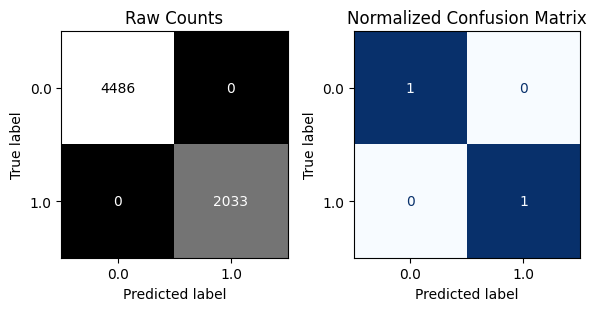


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1127
         1.0       0.66      0.68      0.67       503

    accuracy                           0.79      1630
   macro avg       0.76      0.76      0.76      1630
weighted avg       0.80      0.79      0.79      1630



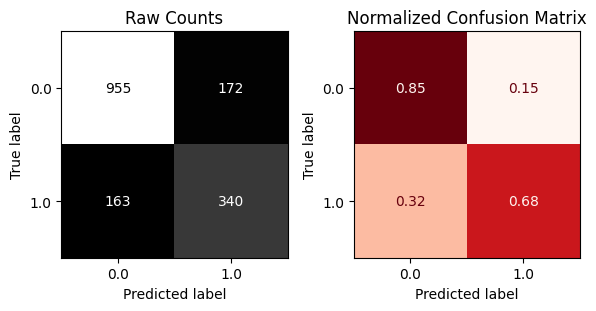

In [111]:
#Evaluating the model
evaluate_classification(decision_tree, X_train_transformed, y_train, X_test_transformed, y_test)

## Visualising information


### Top 10 features

#### Obtaining top 10 features

In [ ]:
#Instantiating permutation importance
r = permutation_importance(decision_tree, X_train_transformed, y_train, n_repeats=15, random_state=42)
r.importances_mean


array([0.05867976, 0.24332975, 0.03539398, 0.09920744, 0.04910774,
       0.15154676, 0.1431917 , 0.04864754, 0.03433042, 0.11439382,
       0.12935522, 0.03045457, 0.01402056, 0.02345963, 0.03155903,
       0.06141024, 0.00490873, 0.00592115, 0.00197372, 0.00603365])

In [ ]:
#Extract the top 10 features using permutation importance
top_features = X_train_transformed.columns[np.argsort(r.importances_mean)[-10:]]
top_features

Index(['MARRIED', 'INCOME', 'AGE', 'GENDER_male', 'VEHICLE_YEAR',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'VEHICLE_OWNERSHIP', 'CREDIT_SCORE',
       'DRIVING_EXPERIENCE'],
      dtype='object')

In [ ]:
#combining X_train_smote and y_train_smote into one dataframe
df_train = pd.DataFrame(X_train_transformed, columns=top_features)
#Converting values in df train back to original values if X_train basing on value counts
for col in df_train.columns:
  #changing columns to object datatype
  if df_train[col].value_counts().index.shape[0] < 25 and col != "GENDER_male":
    df_train[col] = df_train[col].astype('category')
    old = X_train[col].value_counts().index.values
    new = df_train[col].value_counts().index.values
    #Replacing new valued with old values in the list
    c = 0
    for i in new:
      df_train[col] = df_train[col].replace(i,old[c])
      c += 1

df_train['OUTCOME'] = y_train
df_train.sort_index(inplace=True)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6519 entries, 101 to 999976
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   MARRIED             6519 non-null   category
 1   INCOME              6519 non-null   category
 2   AGE                 6519 non-null   category
 3   GENDER_male         6519 non-null   float64 
 4   VEHICLE_YEAR        6519 non-null   category
 5   POSTAL_CODE         6519 non-null   category
 6   ANNUAL_MILEAGE      6519 non-null   category
 7   VEHICLE_OWNERSHIP   6519 non-null   category
 8   CREDIT_SCORE        6519 non-null   float64 
 9   DRIVING_EXPERIENCE  6519 non-null   category
 10  OUTCOME             6519 non-null   float64 
dtypes: category(8), float64(3)
memory usage: 256.5 KB


In [ ]:
df_train.head()

,MARRIED,INCOME,AGE,GENDER_male,VEHICLE_YEAR,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_OWNERSHIP,CREDIT_SCORE,DRIVING_EXPERIENCE,OUTCOME
ID,,,,,,,,,,,
101,1.0,upper class,65+,0.0,before 2015,92101.0,10000.0,0.0,-0.412434,10-19y,0.0
125,0.0,upper class,40-64,1.0,after 2015,10238.0,15000.0,1.0,0.931082,20-29y,0.0
166,0.0,upper class,16-25,1.0,after 2015,10238.0,15000.0,1.0,0.112708,0-9y,0.0
186,1.0,working class,26-39,1.0,before 2015,32765.0,8000.0,0.0,-0.330098,0-9y,0.0
226,0.0,poverty,26-39,1.0,before 2015,10238.0,15000.0,1.0,-0.447393,0-9y,1.0


#### Visulising top 10 features


<ipython-input-198-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-198-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
<ipython-input-198-2f8f12a857e9>:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


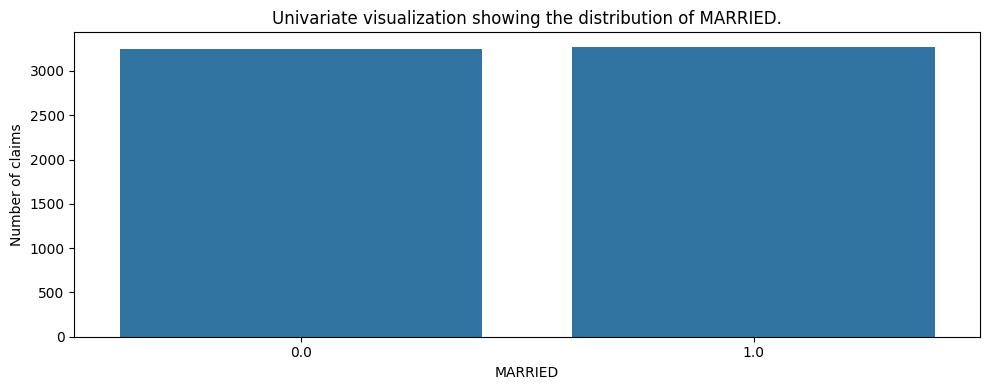

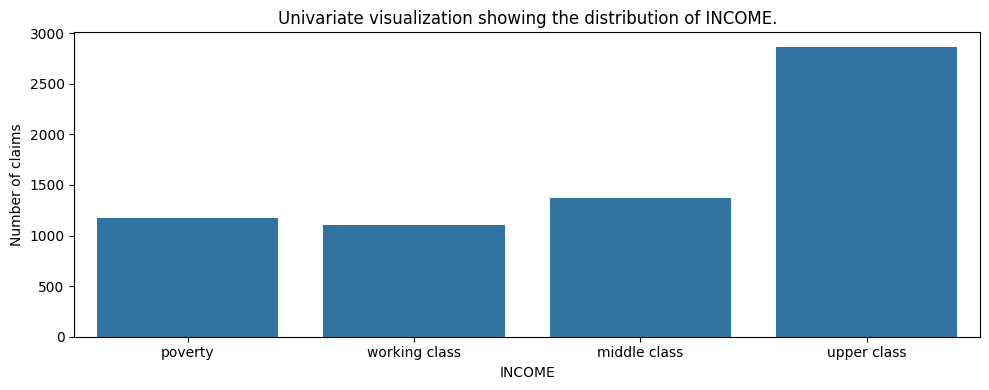

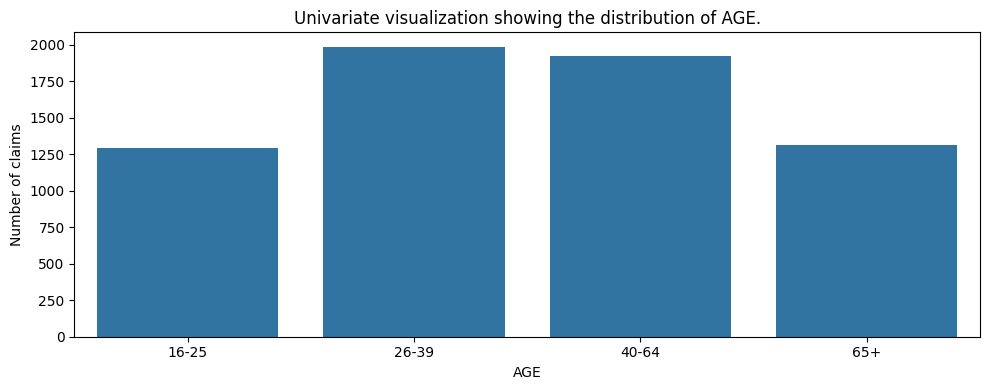

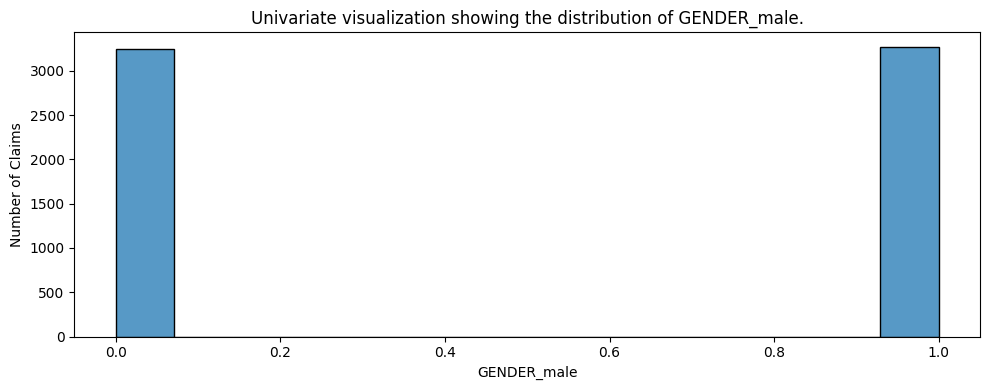

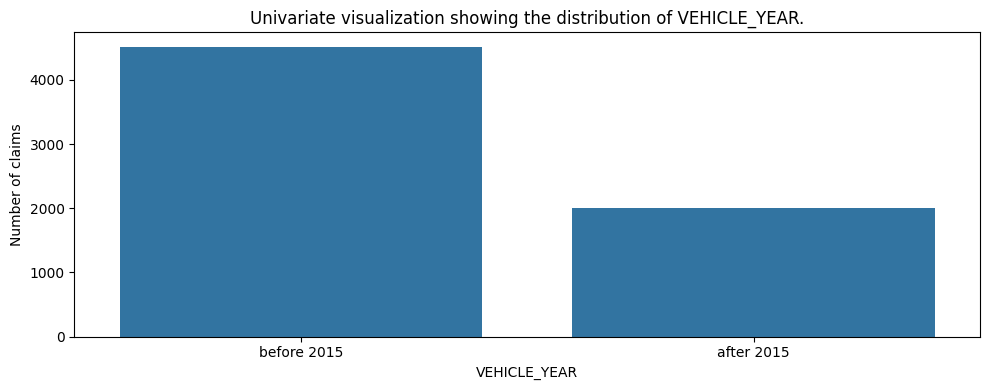

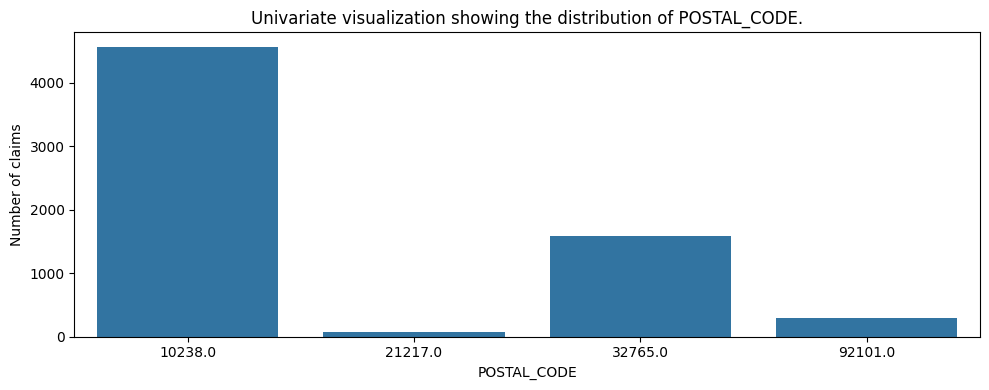

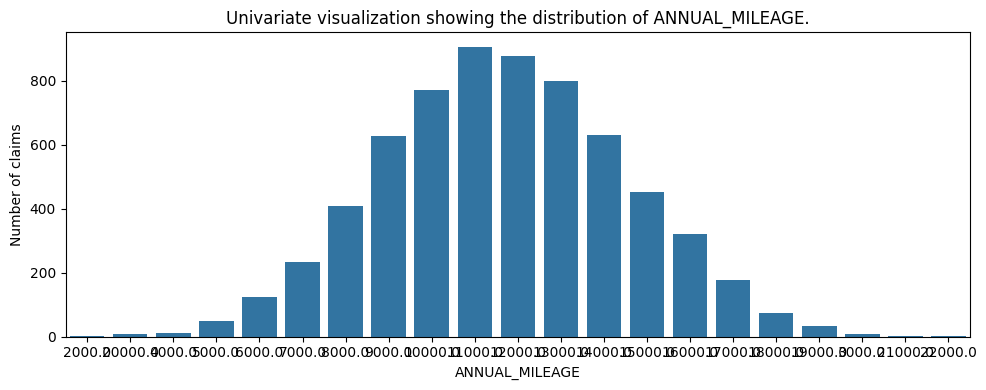

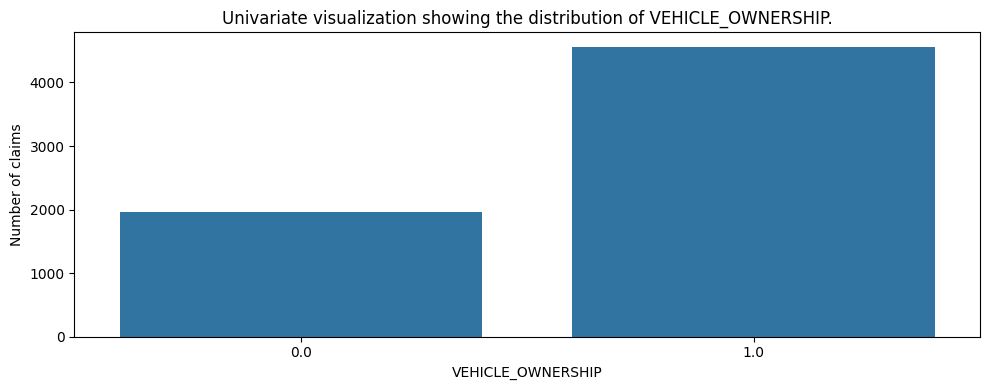

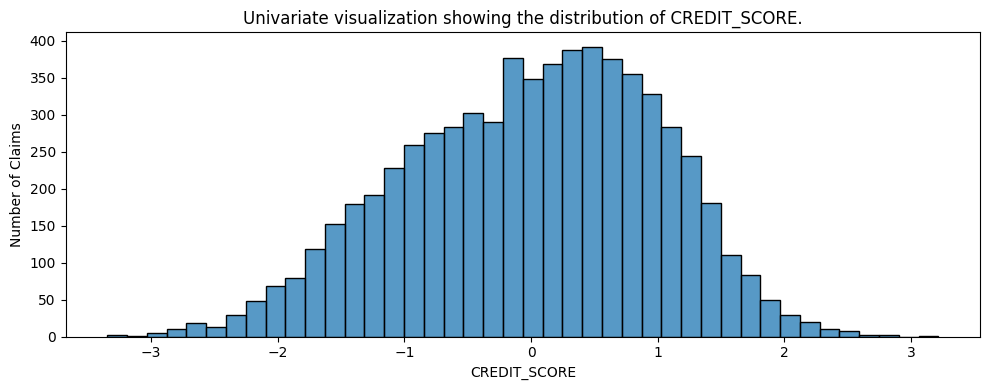

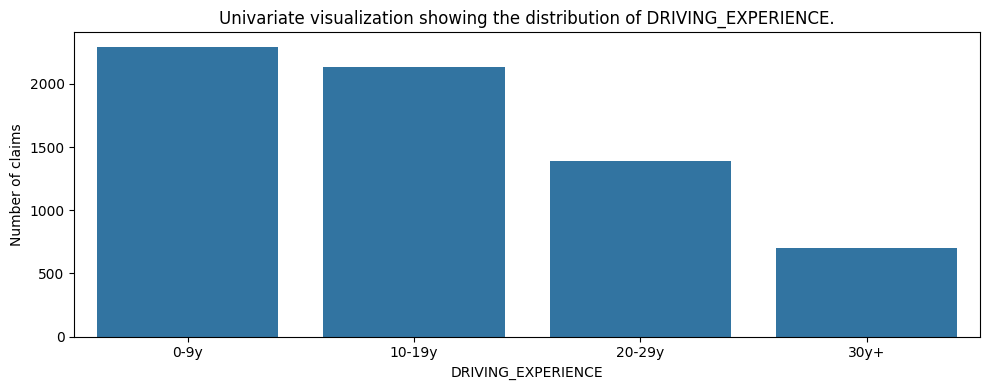

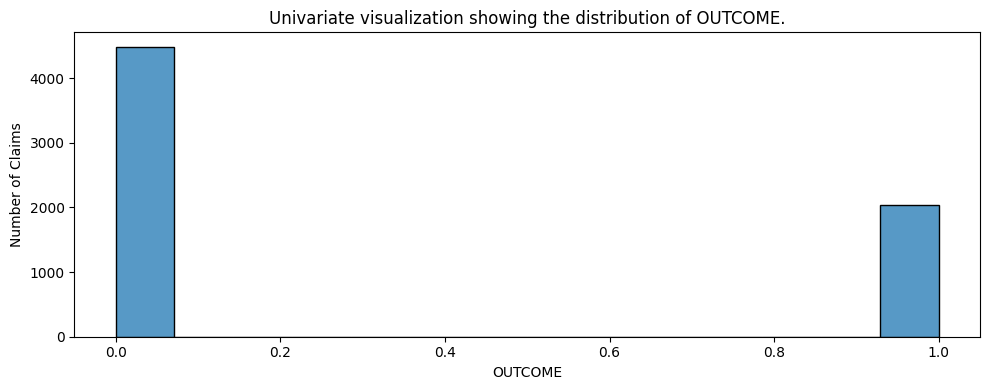

In [ ]:
#Visualising every column in df_train using histplots
for col in df_train.columns:
  univ_viz(df_train, col, figsize=(10,4))






#### Observations
Top 10 features

- MARRIED
- INCOME
- AGE
- GENDER_male
- VEHICLE YEAR
- POSTAL CODE
- ANNUAL MILEAGE
- VEHICLE OWNERSHIP
- CREDIT SCORE
- DRIVING EXPERIENCE

Given the nature of the business, the features make sense; vehicle year, annual milage, credit score, vehicle ownership, income and age can all be key factors in determinig the outcome of a car insurance claim

###Explantory Visualisations


Features to explore further

- Driving experiance
- annual mileage
- income
- age

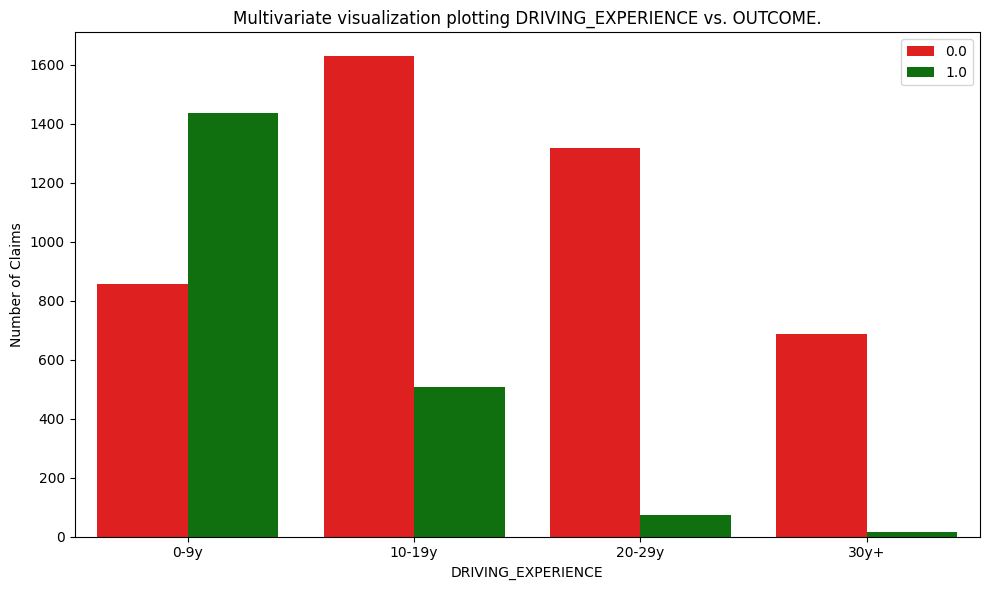

In [ ]:
#Driving Experience
multi_viz(df_train, "DRIVING_EXPERIENCE", "OUTCOME")


<ipython-input-198-2f8f12a857e9>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45);


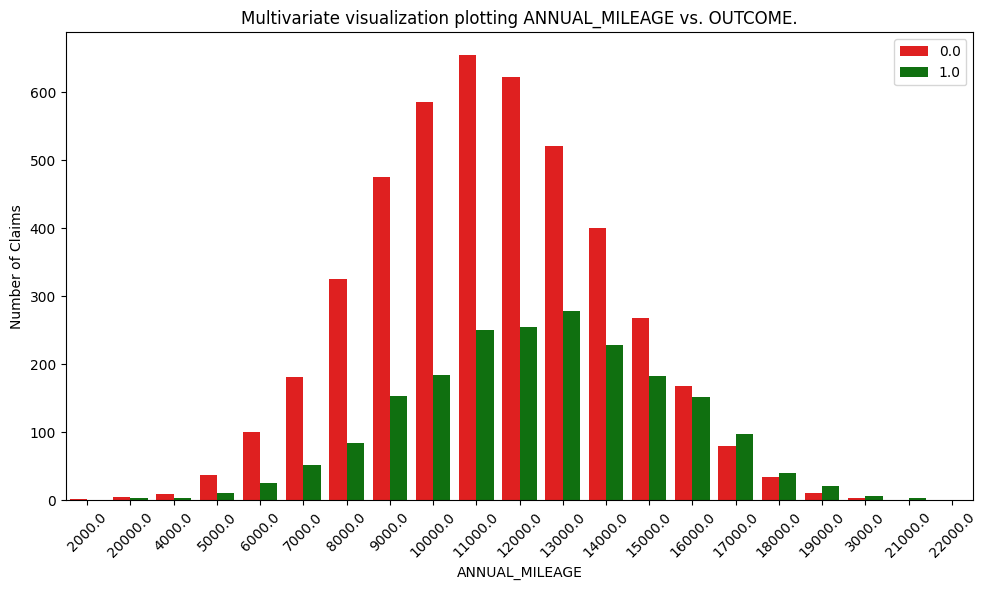

In [ ]:
#Annual Mileage
multi_viz(df_train, "ANNUAL_MILEAGE", "OUTCOME")

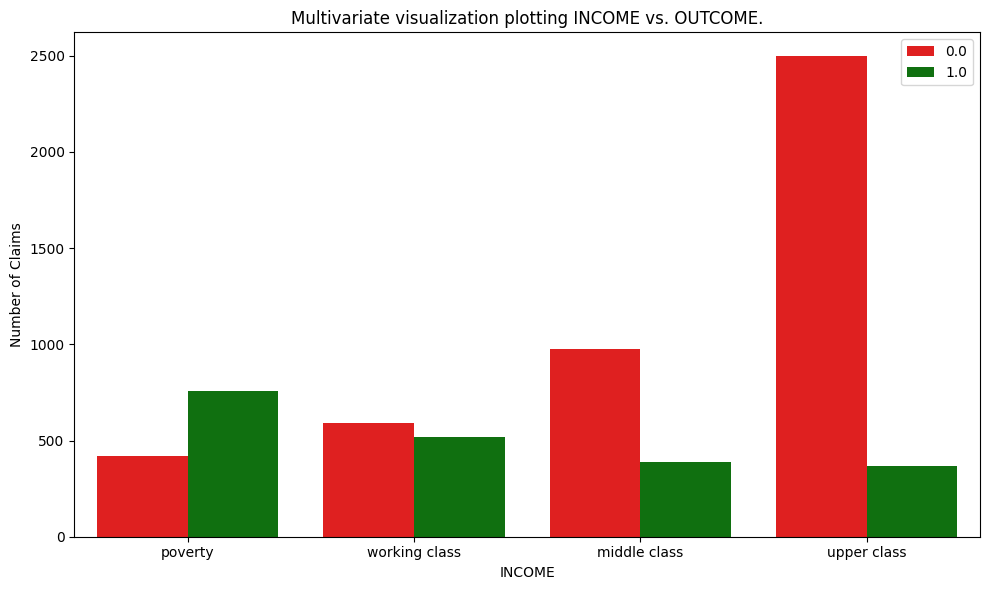

In [ ]:
#Income
multi_viz(df_train, "INCOME", "OUTCOME")

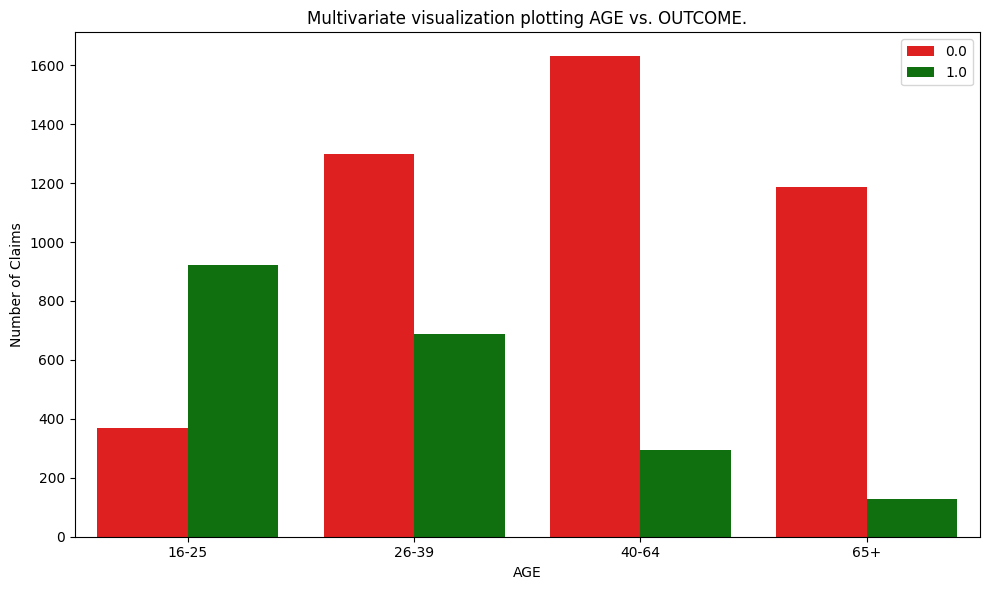

In [ ]:
#Age
multi_viz(df_train, "AGE", "OUTCOME")

## Feature Engineering

### PCA

In [131]:
data = [X_train_transformed, X_test_transformed]

In [132]:
#Instantiate PCA
pca = PCA(n_components = 3)
#Create and define principal components
pca.fit(X_train_transformed)
principal_components_test = pca.transform(X_test_transformed)
principal_components_train = pca.transform(X_train_transformed)
#Preview results
principal_components_test.head()

,pca0,pca1,pca2
ID,,,
325516,-0.286024,-0.460805,-0.828022
55307,0.428978,-1.775103,0.962169
999962,1.745640,-1.982927,-2.083477
998846,3.378701,3.154234,0.381539
471795,-1.702516,0.824548,-1.830539


In [133]:
#Concatenate principal components to data
X_train_pca = pd.concat([X_train_transformed, principal_components_train], axis = 1)
X_test_pca = pd.concat([X_test_transformed, principal_components_test], axis = 1)

Fitting and evaluating the model

In [134]:
#Instantiate model
decision_tree = DecisionTreeClassifier(random_state=42)
#Fit model on Training data
decision_tree.fit(X_train_pca, y_train)
#Predict on test data
train_pred = decision_tree.predict(X_train_pca)
test_pred = decision_tree.predict(X_test_pca)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4486
         1.0       1.00      1.00      1.00      2033

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



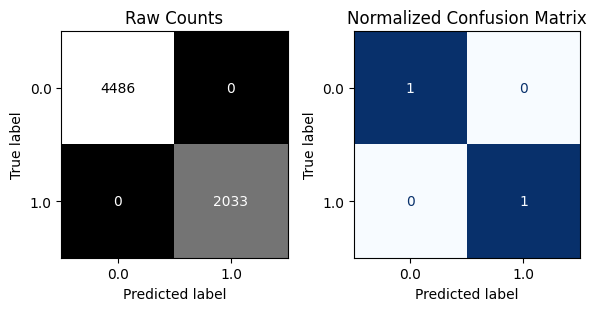


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      1127
         1.0       0.67      0.65      0.66       503

    accuracy                           0.79      1630
   macro avg       0.76      0.76      0.76      1630
weighted avg       0.79      0.79      0.79      1630



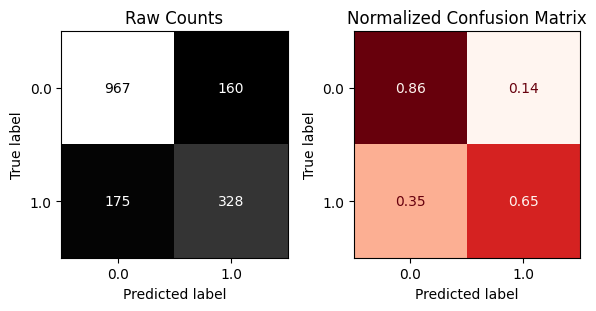

In [135]:
#Evaluating the model
evaluate_classification(decision_tree, X_train_pca, y_train, X_test_pca, y_test)

Compared to the model from part 1:

**Default Model**

|measure|default model|pca model|
|-------|-----|---|
|Accuracy|0.79|0.79|
|False-positives|0.15|0.15|
|False negatives|0.32|0.35|
|precision|0.80|0.79|

The models are very similar with the default model having a very slight margin.



### Feature selection

In [136]:
#Embedded feature selection method

#Instantiate reg model
log_reg = LogisticRegression(random_state=42)
#Instantiate selctor model
selector = SelectFromModel(log_reg)
#Fit selector
selector.fit(X_train_pca, y_train)
#Filter data using selector
above_threshold = selector.get_support()
X_train_sel = X_train_pca.iloc[:,above_threshold]
X_test_sel = X_test_pca.iloc[:,above_threshold]


In [137]:
#Instantiate model
decision_tree = DecisionTreeClassifier(random_state=42)
#Fit model on Training data
decision_tree.fit(X_train_sel, y_train)
#Predict on test data
train_pred = decision_tree.predict(X_train_sel)
test_pred = decision_tree.predict(X_test_sel)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4486
         1.0       1.00      1.00      1.00      2033

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



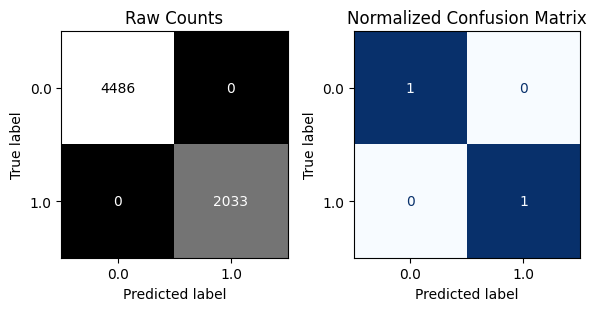


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      1127
         1.0       0.68      0.67      0.67       503

    accuracy                           0.80      1630
   macro avg       0.77      0.76      0.76      1630
weighted avg       0.80      0.80      0.80      1630



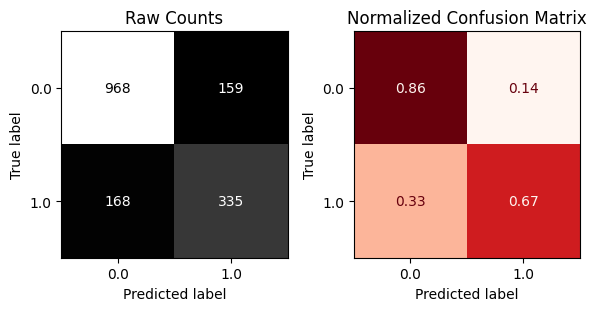

In [138]:
#Evaluating the model
evaluate_classification(decision_tree, X_train_sel, y_train, X_test_sel, y_test)

Compared to the model from part 1:

**Default Model**

|measure|default model|pca model|embedded model|
|---|---|---|---|
|Accuracy|0.79|0.79|0.80|
|False-positives|0.15|0.15|0.14|
|False negatives|0.32|0.35|0.33|
|precision|0.80|0.79|0.80|

The embedded model is better than all previous models

### Top 10 features

#### Obtaining top 10 features

In [139]:
#Instantiating permutation importance
r = permutation_importance(decision_tree, X_train_sel, y_train, n_repeats=15, random_state=42)
r.importances_mean


array([0.21452165, 0.09611904, 0.12455898, 0.1106816 , 0.0293092 ,
       0.07864192, 0.25065194])

In [140]:
#Extract the top 10 features using permutation importance
top_features = X_train_sel.columns[np.argsort(r.importances_mean)[-10:]]
top_features

Index(['GENDER_female', 'GENDER_male', 'VEHICLE_YEAR', 'POSTAL_CODE',
       'VEHICLE_OWNERSHIP', 'DRIVING_EXPERIENCE', 'pca0'],
      dtype='object')

In [151]:
#combining X_train_smote and y_train_smote into one dataframe
df_train = pd.DataFrame(X_train_sel, columns=top_features)
#Converting values in df train back to original values if X_train basing on value counts
for col in df_train.columns:
  #changing columns to object datatype
  if df_train[col].value_counts().index.shape[0] < 25 and col != "GENDER_male" and col !="GENDER_female":
    df_train[col] = df_train[col].astype('category')
    old = X_train[col].value_counts().index.values
    new = df_train[col].value_counts().index.values
    #Replacing new valued with old values in the list
    c = 0
    for i in new:
      df_train[col] = df_train[col].replace(i,old[c])
      c += 1

df_train['OUTCOME'] = y_train.astype('category')
df_train.sort_index(inplace=True)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6519 entries, 101 to 999976
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GENDER_female       6519 non-null   float64 
 1   GENDER_male         6519 non-null   float64 
 2   VEHICLE_YEAR        6519 non-null   category
 3   POSTAL_CODE         6519 non-null   category
 4   VEHICLE_OWNERSHIP   6519 non-null   category
 5   DRIVING_EXPERIENCE  6519 non-null   category
 6   pca0                6519 non-null   float64 
 7   OUTCOME             6519 non-null   category
dtypes: category(5), float64(3)
memory usage: 236.3 KB


In [152]:
df_train.head()

,GENDER_female,GENDER_male,VEHICLE_YEAR,POSTAL_CODE,VEHICLE_OWNERSHIP,DRIVING_EXPERIENCE,pca0,OUTCOME
ID,,,,,,,,
101,1.0,0.0,before 2015,92101.0,0.0,10-19y,0.882344,0.0
125,0.0,1.0,after 2015,10238.0,1.0,20-29y,2.037522,0.0
166,0.0,1.0,after 2015,10238.0,1.0,0-9y,-1.210597,0.0
186,0.0,1.0,before 2015,32765.0,0.0,0-9y,-1.174697,0.0
226,0.0,1.0,before 2015,10238.0,1.0,0-9y,-2.996167,1.0


#### Visulising top 10 features


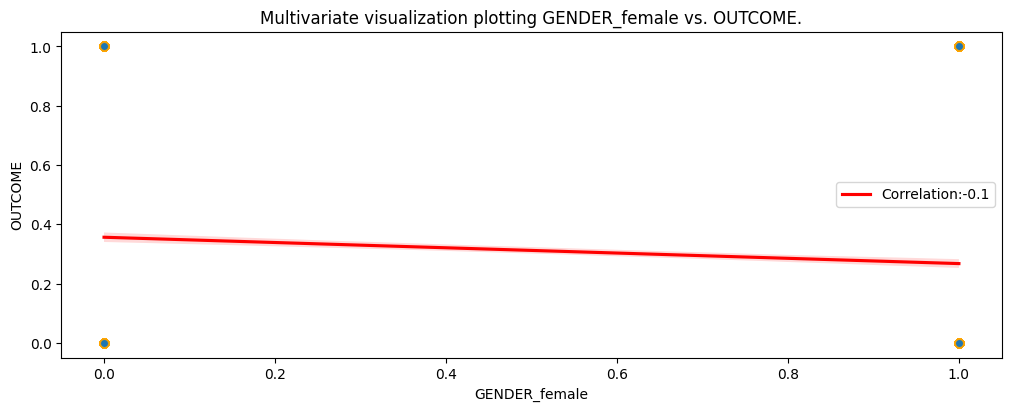

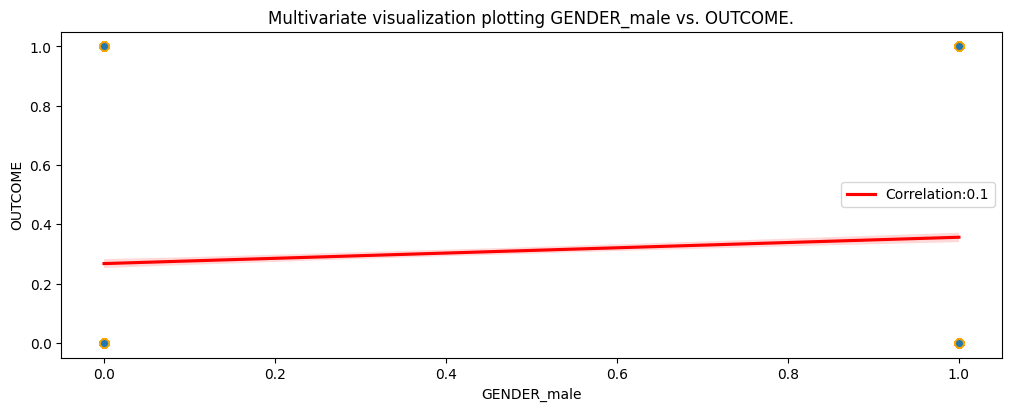

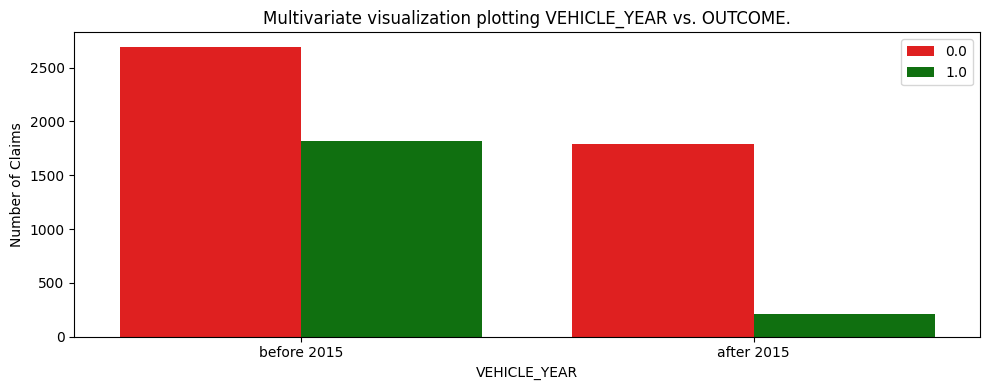

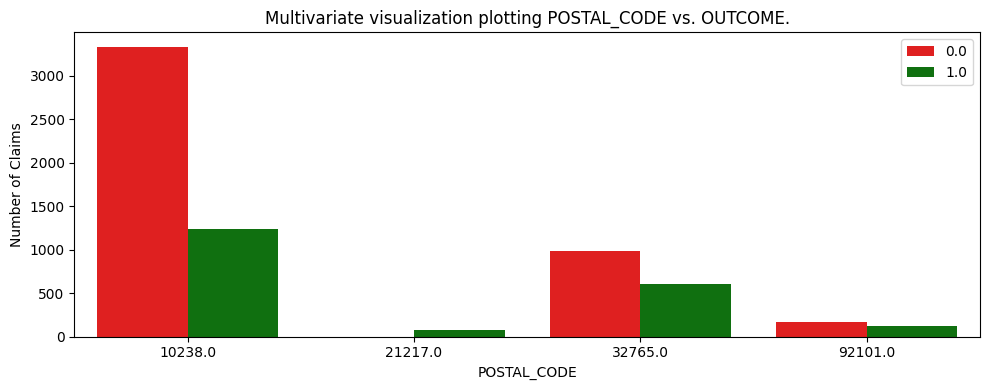

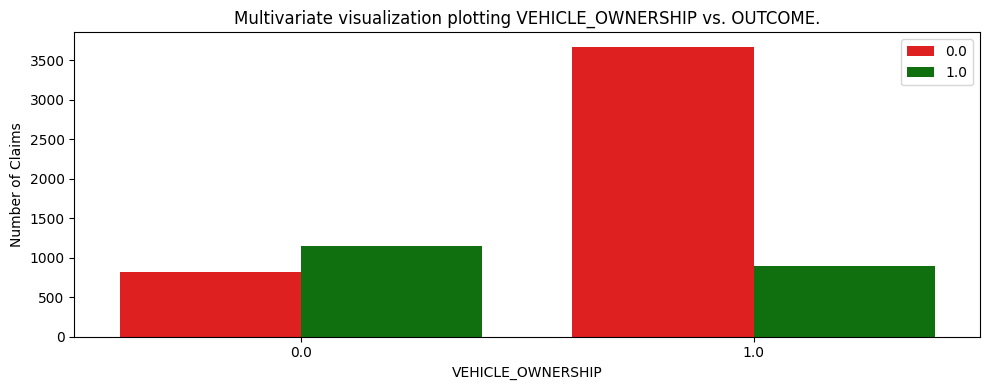

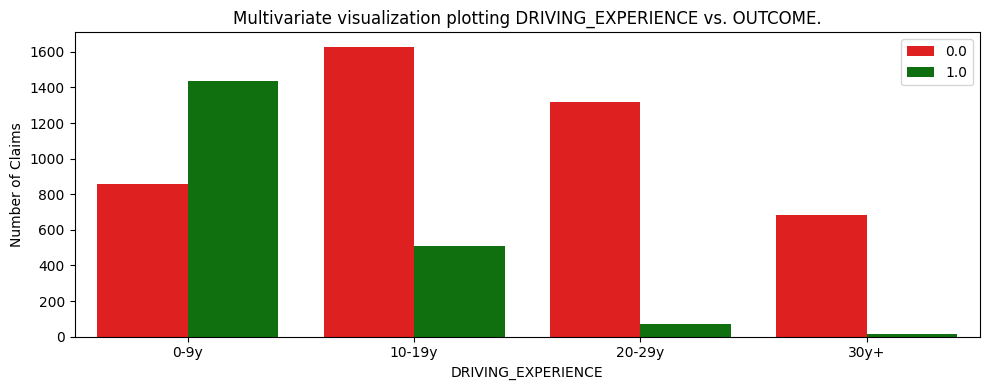

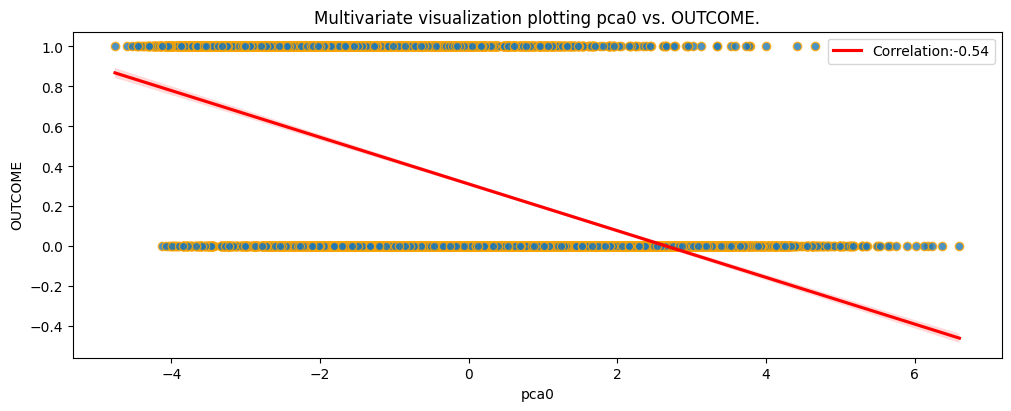

In [153]:
#Visualising every column in df_train using histplots
for col in df_train.columns:
  if col != "OUTCOME":
    multi_viz(df_train, col,"OUTCOME", figsize=(10,4))






#### Observations
Top 7 features

- GENDER_female
- GENDER_male
- VEHICLE YEAR
- POSTAL CODE
- VEHICLE OWNERSHIP
- DRIVING EXPERIENCE
- pca0

Only 7 features met the threshold

Compared to the original model; Age, Income, Married, Annual Mileage and credit score are dropped from top features and are replaced by pca0 and Gender_female.